In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from ggplot import *

RND_STATE = 51834
%matplotlib inline
sns.set_style("whitegrid")

## 1. Loading data

### 1.1 Data load from file

In [2]:
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)

In [3]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


### 1.1 Data exploration

| Variable Name | Description | Type |
| :- | :- | :- |
| SeriousDlqin2yrs | Person experienced 90 days past due delinquency or worse | Y/N |
| RevolvingUtilizationOfUnsecuredLines | Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits | percentage |
| age | Age of borrower in years | integer |
| NumberOfTime30-59DaysPastDueNotWorse | Number of times borrower has been 30-59 days past due but no worse in the last 2 years. | integer |
| DebtRatio | Monthly debt payments, alimony,living costs divided by monthy gross income | percentage |
| MonthlyIncome | Monthly income | real |
| NumberOfOpenCreditLinesAndLoans | Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards) | integer |
| NumberOfTimes90DaysLate | Number of times borrower has been 90 days or more past due. | integer |
| NumberRealEstateLoansOrLines | Number of mortgage and real estate loans including home equity lines of credit | integer |
| NumberOfTime60-89DaysPastDueNotWorse | Number of times borrower has been 60-89 days past due but no worse in the last 2 years. | integer |
| NumberOfDependents | Number of dependents in family excluding themselves (spouse, children etc.) | integer |






### 1.2 Checking if classes are imbalanced

In [4]:
def plotClassBalance(classesData):
    ax = sns.countplot(x = classesData)
    ax.set_title('Dataset class balance check')
    ax.set_xlabel('Person experienced 90 days past due delinquency or worse ')
    ax.set_ylabel('Count')
    plt.show()

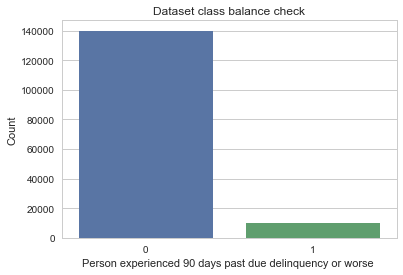

In [5]:
plotClassBalance(data.SeriousDlqin2yrs)

### 1.3 Checking for NAN values

In [6]:
def checkDataFrameNANs(df):
    print('Number of nans by property:')
    print(df.isnull().sum())

In [7]:
checkDataFrameNANs(data)

Number of nans by property:
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


## 2. Data preprocessing

### 2.1 Working with NANs

#### 2.1.1 Working with NumberOfDependents parameter 

Рассматриваемый датасет содержит пропуски в параметре NumberOfDependents. Пропусков достаточно немного, и, чтобы не удалять значения, заменим пропуски в данных медианными значениями.

In [8]:
data['NumberOfDependents'].fillna(data['NumberOfDependents'].median(), inplace = True)

#### 2.1.2 Working with MonthlyIncome parameter 

В используемом датасете очень много пустых значений параметра MonthlyIncome. 
Построим линейную регрессию для восстановления значений параметра.

In [9]:
non_null_data_monInc = data[data.MonthlyIncome.isnull() == False]
null_monInc = data[data.MonthlyIncome.isnull() == True]

monInc_y_train = non_null_data_monInc.MonthlyIncome
monInc_X_train = non_null_data_monInc.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis = 1)
null_monInc = null_monInc.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis=1)

monIncLR = LinearRegression(fit_intercept=True, normalize=True).fit(monInc_X_train, monInc_y_train)

С помощью полученной модели предскажем значения параметра для NAN значений 

In [10]:
monInc_y_pred = monIncLR.predict(null_monInc)
monInc_y_pred[monInc_y_pred < 0] = 0
null_monInc['MonthlyIncome'] = monInc_y_pred

In [11]:
monNew = []
for index in data.index:
    if data.MonthlyIncome[index].is_integer() == True:
        monNew.append(data.MonthlyIncome[index])
    else:
        monNew.append(null_monInc.MonthlyIncome[index])
data.MonthlyIncome = monNew

#### 2.1.3 Cheking for NANs again

In [12]:
print('Number of nans by property:')
checkDataFrameNANs(data)

Number of nans by property:
Number of nans by property:
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


### 2.2 Train test split

In [13]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data.SeriousDlqin2yrs

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = RND_STATE)

### 2.3 Oversampling minor class

Train subset balance before oversampling

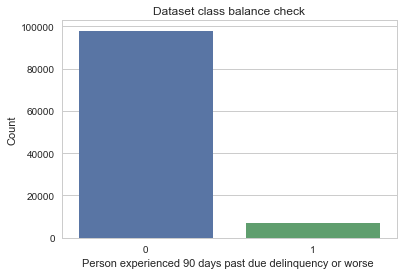

In [16]:
plotClassBalance(y_train)

In [17]:
sm = SMOTE(random_state = RND_STATE)
X_res, y_res = sm.fit_sample(X_train, y_train)

And after oversampling

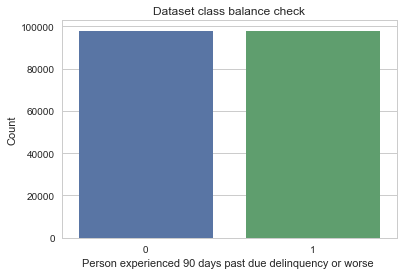

In [18]:
plotClassBalance(y_res)

In [19]:
X_train = X_res.copy()
y_train = y_res.copy()

## 3. Data prediction

### 3.1 Building models

#### 3.1.1 Gradient Boosting

In [ ]:
folds = StratifiedKFold(n_splits = 10, random_state = RND_STATE, shuffle = False)
#создаем объект класса GradientBoostingClassifier() с определенным набором параметров
gb = GradientBoostingClassifier(learning_rate = 0.1, subsample = 0.7,  
                                max_features = 'sqrt', random_state = RND_STATE)
#устанавливаем диапозон параметров для скользящего контроля
gb_params = {'loss': ['deviance', 'exponential'],
             'min_samples_leaf': [2, 3, 4, 5], 
             'n_estimators': [150], 'random_state' : [RND_STATE]}
#создаем объект класса GridSearchCV()
gb_cv = GridSearchCV(gb, param_grid = gb_params, scoring = 'roc_auc', cv = folds, n_jobs = -1)
#обучаемся на обучающей выборке
gb_cv.fit(X_train, y_train)
#делаем предсказание меток класса на тестовой
gb_cv_predict = gb_cv.predict(X_test)
#делаем предсказание вероятности класса на тестовой
gb_cv_predict_proba = gb_cv.predict_proba(X_test)[:, 1]
#вычисляем значение метрики 
roc_auc_gb = roc_auc_score(y_test, gb_cv_predict_proba)

In [ ]:
print("ROC AUC score:", roc_auc_gb,
      "CV best score:", gb_cv.best_score_)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, gb_cv_predict_proba)
print(str('False positive rate:') + '\n' + str(fpr) + '\n\n' +
      str('True positive rate:') + '\n' + str(tpr) + '\n\n' +
      str('Thresholds:') + '\n' + str(thresholds))

In [ ]:
print("ROC AUC score:", auc(fpr, tpr))

In [ ]:
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y ='tpr')) +\
    geom_line(color='blue', size = 2, alpha = 0.5) +\
    geom_abline(linetype = 'dashed') +\
    xlab("false positive rate ($fpr$)") + ylab("true positive rate ($tpr$)") + ggtitle("ROC curve")

In [ ]:
importances_gb = gb_cv.best_estimator_.feature_importances_ #получение весов признаков
print(str("Топ - 5 важнейших признаков:") + '\n')
gb_zip = zip(X.columns, importances_gb) 
for a, b, in sorted(gb_zip, key = lambda zp_gb: zp_gb[1], reverse = True)[:5]:
    print("{0}: {1}".format(a, b))

#### 3.1.2 Random Forest

In [ ]:
#количество n_splits было увеличено, чтобы избежать переобучения
folds = StratifiedKFold(n_splits = 25, random_state = RND_STATE) 
#набор параметров
params = {'criterion': ['gini', 'entropy'], 
         'max_features': [1, 5, 10, 'log2', 'auto'],
         'max_depth': [2, 4, 8, 16, 32], 
         'class_weight': ['balanced'], 'random_state' : [RND_STATE]}
#создание объекта класса GridSearchCV()
rf_cv = GridSearchCV(RandomForestClassifier(), params, 
                     scoring='roc_auc', n_jobs = -1, cv = folds)
#обучение модели
rf_cv.fit(X_train, y_train)
#предсказание меток класса
rf_cv_prediction = rf_cv.predict(X_test)
#предсказание вероятности принадлежности к одному из классов
rf_cv_prediction_proba = rf_cv.predict_proba(X_test)[:, 1]
#вычисляем значение метрики 
roc_auc_rf = roc_auc_score(y_test, rf_cv_prediction_proba)

In [ ]:
print("ROC AUC score:", roc_auc_rf,
      "CV best score:", rf_cv.best_score_)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, rf_cv_prediction_proba)
print(str('False positive rate:') + '\n' + str(fpr) + '\n\n' +
      str('True positive rate:') + '\n' + str(tpr) + '\n\n' +
      str('Thresholds:') + '\n' + str(thresholds))

In [ ]:
print("ROC AUC score:", auc(fpr, tpr))

In [ ]:
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y ='tpr')) +\
    geom_line(color='red', size = 2, alpha = 0.5) +\
    geom_abline(linetype = 'dashed') +\
    xlab("false positive rate ($fpr$)") + ylab("true positive rate ($tpr$)") + ggtitle("ROC curve")

In [ ]:
importances_rf = rf_cv.best_estimator_.feature_importances_ #получение весов признаков
print(str("Топ - 5 важнейших признаков:") + '\n')
rf_zip = zip(X.columns, importances_rf) 
for a, b, in sorted(rf_zip, key = lambda zp_rf: zp_rf[1], reverse = True)[:5]:
    print("{0}: {1}".format(a, b))

#### 3.1.3 Logistic Regression

In [ ]:
#создаем объект класса XGBClassifier() с определенным набором параметров
lr = LogisticRegression(class_weight = 'balanced', random_state = RND_STATE)
#устанавливаем диапозон параметров для скользящего контроля
lr_params = {'penalty': ['l1', 'l2'], 
             'C': [0.5, 0.8, 1.0], 'random_state' : [RND_STATE]}
#создаем объект класса GridSearchCV()
lr_cv = GridSearchCV(lr, param_grid = lr_params, scoring = 'roc_auc', cv = folds, n_jobs = -1)
#обучаемся на обучающей выборке
lr_cv.fit(X_train, y_train)
#делаем предсказание меток класса на тестовой
lr_cv_predict = lr_cv.predict(X_test)
#делаем предсказание вероятности класса на тестовой
lr_cv_predict_proba = lr_cv.predict_proba(X_test)[:, 1]
#вычисляем значение метрики 
roc_auc_lr = roc_auc_score(y_test, lr_cv_predict_proba)

In [ ]:
print("ROC AUC score:", roc_auc_lr,
      "CV best score:", lr_cv.best_score_)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, lr_cv_predict_proba)
print(str('False positive rate:') + '\n' + str(fpr) + '\n\n' +
      str('True positive rate:') + '\n' + str(tpr) + '\n\n' +
      str('Thresholds:') + '\n' + str(thresholds))

In [ ]:
print("ROC AUC score:", auc(fpr, tpr))

In [ ]:
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y ='tpr')) +\
    geom_line(color='green', size = 2, alpha = 0.5) +\
    geom_abline(linetype = 'dashed') +\
    xlab("false positive rate ($fpr$)") + ylab("true positive rate ($tpr$)") + ggtitle("ROC curve")

In [ ]:
importances_lr = lr_cv.best_estimator_.coef_.flatten()
print(str("Топ - 5 важнейших признаков:") + '\n')
lr_zip = zip(X.columns, importances_lr) 
for a, b, in sorted(lr_zip, key = lambda zp_lr: zp_lr[1], reverse = True)[:5]:
    print("{0}: {1}".format(a, b))